# Lesson 9 Assignment - BayesOpEd

## Author - Lawrence Huang

## Instructions


1. Leverage Naïve Bayes algorithm to classify build a model using the data from previous milestones.
2. Briefly summarize your findings on using Naïve Bayes.
3. Is Naïve Bayes more accurate than the regression model you used in Milestone 3?

As part of the modeling process, you might need to convert the data into categorical form to apply Naïve Bayes.<br>
As a hint, if you have numerical attributes, use binning to convert them to categorical.

#### 1. Leverage Naïve Bayes algorithm to classify build a model using the data from previous milestones.

#### Dataset used in Milestone 3: King County Housing dataset
Location: https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv

#### Overall problem statement:  Predict the price of a house in King County.
Use case: A developer interested in acquiring properties in King County, Washington is interested in what home features (zip code, structure, etc) would yield a high price. 
#### For this exercise, the problem is reframed as a classification problem: predict whether house price exceeds 500K

In [1]:
# Load necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

# Load and view data
url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
house_orig = pd.read_csv(url)
house_orig.head()

# make a copy of the dataframe
house = house_orig.copy()

##### Data preparation
Strategy: convert numeric data into categorical form by binning

In [2]:
# all columns except date are of int/float type 
# find number of NANs/missing values
print('data types:')
print(house.dtypes)
print('\nnumber of nan values: {}'.format(house.isna().sum().sum()))

data types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

number of nan values: 0


In [3]:
# drop id, since it appears to be independent of price 
# it is a "key", with with almost as many unique values as observations
print('unique values for id: {}'.format(house['id'].nunique()))
cols_to_drop = ['id']

unique values for id: 21436


In [4]:
# date may be useful as a feature, even though the data only spans 1 year
# change date to ordinal, then make 10 equal-sized bins
house['date'] = pd.to_datetime(house['date'])
house['date_bin'] = house['date'].map(dt.datetime.toordinal)
house['date_bin'] = pd.qcut(house['date_bin'], 10)
# print('verify # observations after binning: {}'.format(house['date_bin'].value_counts().sum()))
cols_to_drop.append('date')
cols_to_encode = ['date_bin']

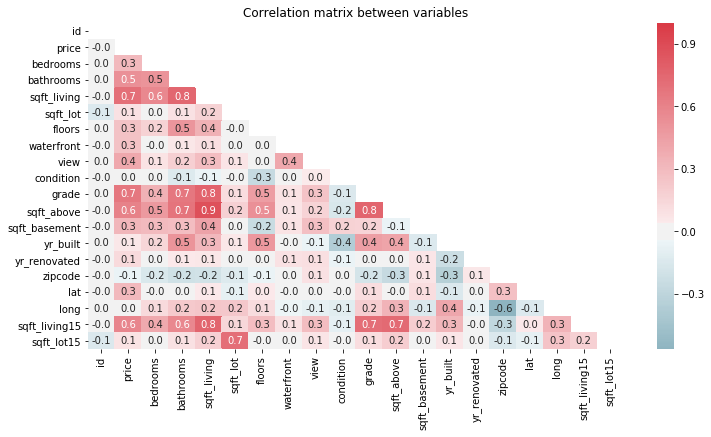

In [5]:
# Examine correlation between variables.
corrmat = house.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # diverging colormap
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
sns.heatmap(corrmat, mask=mask, annot=True, cmap=cmap, fmt='.1f', center=0, ax=ax)
ax.set_title('Correlation matrix between variables')
plt.show()

In [6]:
# find pairs with highest correlations (corr coeff>0.6)
corrmat = house.corr().abs()
np.fill_diagonal(corrmat.values, np.nan)
corr_series = corrmat.unstack()
corr_series_ordered = corr_series.sort_values(ascending=False)
print('pairs with the highest correlation:\n(variable 1, variable 2, correlation coeff)')
corr_series_ordered[corr_series_ordered>0.6][1::2]

pairs with the highest correlation:
(variable 1, variable 2, correlation coeff)


sqft_living    sqft_above     0.876597
grade          sqft_living    0.762704
sqft_living15  sqft_living    0.756420
grade          sqft_above     0.755923
bathrooms      sqft_living    0.754665
sqft_living15  sqft_above     0.731870
sqft_lot15     sqft_lot       0.718557
sqft_living15  grade          0.713202
price          sqft_living    0.702035
sqft_above     bathrooms      0.685342
grade          price          0.667434
bathrooms      grade          0.664983
price          sqft_above     0.605567
dtype: float64

In [7]:
# bins for price: <=500K, >500K
house['price_bin'] = pd.cut(house['price'], bins=[0, 5e5, np.max(house['price'])], labels=[0, 1], include_lowest=True)
# print('verify # observations after binning: {}'.format(house['price_bin'].value_counts().sum()))
cols_to_drop.append('price')

In [8]:
# bins for bedrooms: <=3, >3
house['bedrooms_bin'] = pd.cut(house['bedrooms'], bins=[0, 3, np.max(house['bedrooms'])], labels=[0, 1], include_lowest=True)
# print('verify # observations after binning: {}'.format(house['bedrooms_bin'].value_counts().sum()))
cols_to_drop.append('bedrooms')

In [9]:
# bins for bathrooms: <=2, >2
house['bathrooms_bin'] = pd.cut(house['bathrooms'], bins=[0, 2, np.max(house['bathrooms'])], labels=[0, 1], include_lowest=True)
house['bathrooms_bin'].value_counts()
# print('verify # observations after binning: {}'.format(house['bathrooms_bin'].value_counts().sum()))
cols_to_drop.append('bathrooms')

In [10]:
# bins for sqft_living: 10 equal-sized bins
house['sqft_living_bin'] = pd.qcut(house['sqft_living'], 10)
# print('verify # observations after binning: {}'.format(house['sqft_living_bin'].value_counts().sum()))
cols_to_drop.append('sqft_living')
cols_to_encode.append('sqft_living_bin')

In [11]:
# bins for sqft_lot: 10 equal-sized bins
house['sqft_lot_bin'] = pd.qcut(house['sqft_lot'], 10)
# print('verify # observations after binning: {}'.format(house['sqft_lot_bin'].value_counts().sum()))
cols_to_drop.append('sqft_lot')
cols_to_encode.append('sqft_lot_bin')

In [12]:
# bins for floors: <=1, >1
house['floors_bin'] = pd.cut(house['floors'], bins=[0, 1, np.max(house['floors'])], labels=[0, 1], include_lowest=True)
# print('verify # observations after binning: {}'.format(house['floors_bin'].value_counts().sum()))
cols_to_drop.append('floors')

In [13]:
# change waterfront to categorical
house['waterfront'] = house['waterfront'].astype('category')

In [14]:
# view, condition, grade are categorical because they have a small number of discrete numeric values and are qualitative.
# function to convert ordinal variables to category type
def custom_ordinal_encoder(col):
    cat_dtype = pd.api.types.CategoricalDtype(categories=sorted(house[col].unique()), ordered=True)
    return house[col].astype(cat_dtype)

# convert ordinal variables to category type
house['view_cat'] = custom_ordinal_encoder('view')
house['condition_cat'] = custom_ordinal_encoder('condition')
#house['grade_cat'] = custom_ordinal_encoder('grade')

# as shown above, grade is highly correlated with a number of variables (some of which also will not be selected for modeling):
# sqft_living, sqft_above, sqft_living15, bathrooms 
# exclude grade (but including grade also does not noticably change the predictions)
cols_to_drop.extend(['view', 'condition', 'grade'])

In [15]:
# sqft_living = sqft_above + sqft_basement; there are many zeros in sqft_basement, so sqft_above dominates sqft_living.
cols_to_drop.append('sqft_above')

In [16]:
# there are many zeros in sqft_basement; create new binary feature to indicate if house has basement or not
house['basement_cat'] = house['sqft_basement'].apply(lambda yr: 0 if yr == 0 else 1)
house['basement_cat'] = house['basement_cat'].astype('category')
cols_to_drop.append('sqft_basement')

In [17]:
# bins for yr_built: 10 equal-sized bins
house['yr_built_bin'] = pd.qcut(house['yr_built'], 10)
# print('verify # observations after binning: {}'.format(house['yr_built_bin'].value_counts().sum()))
cols_to_drop.append('yr_built')
cols_to_encode.append('yr_built_bin')

In [18]:
# there are many zeros in yr_renovated; create new binary feature renovated to indicate if house has been renovated or not
house['renovated'] = house['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)
house['renovated'] = house['renovated'].astype('category')
cols_to_drop.append('yr_renovated')

In [19]:
# encode zipcode
cols_to_encode.append('zipcode')

In [20]:
# bins for lat: 10 equal-sized bins
house['lat_bin'] = pd.qcut(house['lat'], 10)
# print('verify # observations after binning: {}'.format(house['lat_bin'].value_counts().sum()))
cols_to_drop.append('lat')
cols_to_encode.append('lat_bin')

In [21]:
# bins for long: 10 equal-sized bins
house['long_bin'] = pd.qcut(house['long'], 10)
# print('verify # observations after binning: {}'.format(house['long_bin'].value_counts().sum()))
cols_to_drop.append('long')
cols_to_encode.append('long_bin')

In [22]:
# sqft_living15, sqft_lot15 are colinear to other features of similar names (sqft_living, sqft_lot, respectively). Differences between these similar named variables are unclear.
# drop sqft_living15, sqft_lot15
cols_to_drop.extend(['sqft_living15', 'sqft_lot15'])

In [23]:
# encode new variables
enc = OrdinalEncoder()
house[cols_to_encode] = enc.fit_transform(house[cols_to_encode])
house['zipcode'] = house['zipcode'].astype(int)
house[cols_to_encode] = house[cols_to_encode].astype(int).astype('category')

# drop designated columns
house.drop(cols_to_drop, axis=1, inplace=True)

In [24]:
# view dataset
house.head()

,waterfront,zipcode,date_bin,price_bin,bedrooms_bin,bathrooms_bin,sqft_living_bin,sqft_lot_bin,floors_bin,view_cat,condition_cat,basement_cat,yr_built_bin,renovated,lat_bin,long_bin
0,0,66,4,0,0,0,1,3,0,0,3,0,2,0,3,4
1,0,55,6,1,0,1,7,4,1,0,3,1,2,1,8,2
2,0,16,7,0,0,0,0,7,0,0,3,0,1,0,9,4
3,0,58,6,1,1,1,5,2,0,0,5,1,3,0,3,0
4,0,37,7,1,0,0,3,5,0,0,3,0,6,0,5,8


##### Train/test split

In [25]:
# train/test split
y = house['price_bin']
#X = house.loc[:, ~house.columns.isin(['price_bin'])]
# better area under ROC curve when zipcode excluded
X = house.loc[:, ~house.columns.isin(['price_bin', 'zipcode'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('features: {}'.format(X.columns.values))

features: ['waterfront' 'date_bin' 'bedrooms_bin' 'bathrooms_bin' 'sqft_living_bin'
 'sqft_lot_bin' 'floors_bin' 'view_cat' 'condition_cat' 'basement_cat'
 'yr_built_bin' 'renovated' 'lat_bin' 'long_bin']


##### Naive Bayes model

In [26]:
mnb = MultinomialNB() # use default laplace smoothing
mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X_test)
y_prob_mnb = mnb.predict_proba(X_test)

# confusion matrix based on default 0.5 probability threshold
print ('Confusion Matrix using default 0.5 probability threshold:')
print(confusion_matrix(y_test, y_pred_mnb)) 
print(classification_report(y_test, y_pred_mnb))

Confusion Matrix using default 0.5 probability threshold:
[[1974  503]
 [ 629 1217]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2477
           1       0.71      0.66      0.68      1846

    accuracy                           0.74      4323
   macro avg       0.73      0.73      0.73      4323
weighted avg       0.74      0.74      0.74      4323



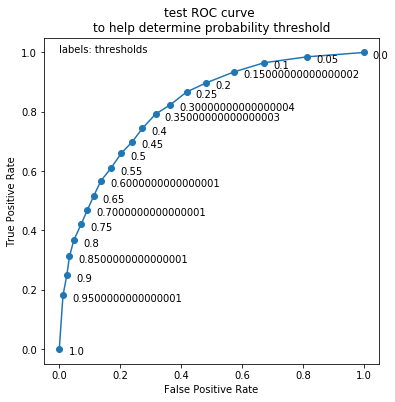

threshold on ROC curve that is closest to the top-left: 0.4


In [27]:
# Explore probability threshold:
# The ROC curve was used to help determine an appropriate probability threshold. 
# Specifically, a threshold that is based on the point in an ROC curve that is closest to the top-left corner was used.

# test a few thresholds from 0 to 1
test_thrs = np.arange(0, 1.05, 0.05)
temp_tprs = np.array([])
temp_fprs = np.array([])
for test_thr in test_thrs:
    # predict class labels based on custom threshold, using prob of classification for outcome/class 1
    temp_prediction = (y_prob_mnb[:,1]>test_thr).astype(int) 
    cm_temp = confusion_matrix(y_test, temp_prediction) # get confusion matrix
    tn_temp, fp_temp, fn_temp, tp_temp = cm_temp.ravel() 
    temp_tprs = np.append(temp_tprs, tp_temp/(tp_temp+fn_temp)) # get tprs to plot ROC curve
    temp_fprs = np.append(temp_fprs, fp_temp/(fp_temp+tn_temp)) # get fprs to plot ROC curve

# plot test ROC curve
plt.figure(figsize=[6,6])
plt.plot(temp_fprs, temp_tprs,'o-')
for i, x in enumerate(zip(temp_fprs, temp_tprs)):
    plt.text(x[0]+0.03, x[1]-0.02, test_thrs[i])
plt.title('test ROC curve \nto help determine probability threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(np.min(temp_fprs), np.max(temp_tprs), 'labels: thresholds')
plt.show()

# opt for the threshold that is based on the point in an ROC curve that is closest to the top-left corner
dist_top_left = np.sqrt((temp_tprs-1)**2+(temp_fprs-0)**2) # distance to top-left corner
thr = np.round(test_thrs[np.argmin(dist_top_left)],2) # specify custom threshold closest to top-left corner

print('threshold on ROC curve that is closest to the top-left: {}'.format(thr))

In [28]:
# predict class labels based on custom threshold, using prob of classification for outcome/class 1 (Price>500K)
y_pred_mnb_custom = (y_prob_mnb[:,1]>thr).astype(int)
# confusion matrix from predicted values
cm_mnb_custom = confusion_matrix(y_test, y_pred_mnb_custom)
print ('\nConfusion Matrix using probability threshold {}:'.format(thr))
print(cm_mnb_custom)
tn, fp, fn, tp = cm_mnb_custom.ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)

# Classification report
print ('\nMetrics based on confusion matrix:')
print(classification_report(y_test, y_pred_mnb_custom))


Confusion Matrix using probability threshold 0.4:
[[1800  677]
 [ 472 1374]]

TP, TN, FP, FN: 1374 , 1800 , 677 , 472

Metrics based on confusion matrix:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2477
           1       0.67      0.74      0.71      1846

    accuracy                           0.73      4323
   macro avg       0.73      0.74      0.73      4323
weighted avg       0.74      0.73      0.74      4323



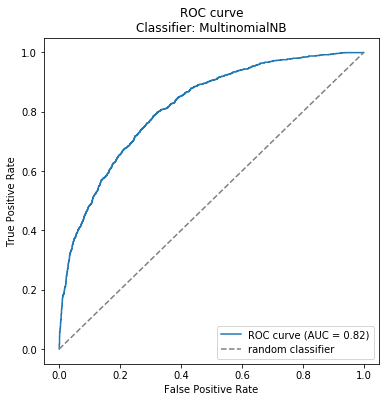

In [29]:
# Calculate the ROC curve and its AUC 
# get false positive rate, true posisive rate, probability thresholds
fpr, tpr, thrs = roc_curve(y_test, y_prob_mnb[:,1])
# get area under the curve
area_under_curve = auc(fpr, tpr)

# plot ROC curve with AUC score
plt.figure(figsize=[6,6])
plt.title('ROC curve\nClassifier: '+type(mnb).__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], c='gray', linestyle='--', label='random classifier')
plt.legend(loc="lower right")
plt.show()

#### 2. Briefly summarize your findings on using Naïve Bayes.

<ul>
    <li>
A Multinomial Naive Bayes classifier was used for a binary classification problem: to predict whether house price exceeds 500K.
    </li>
<li>
Numerical attributes were binned and converted to categorical. The "price" column was converted to the label "price_bin", with 0=less than or equal to 500K and 1=greater than 500K.
    </li>
<li>
The model was evaluated based on confusion matrix-derived metrics and area under the ROC curve. For confusion matrix-derived metrics, the ROC curve was used to help pick a probability threshold, and the point on the ROC curve that was closest to the top-left corner was selected (here, probability threshold of 0.4).
    </li>
<li>
From the resultant confusion matrix, the macro average precision was 0.73, recall was 0.74, and f-1 score was 0.73. Accuracy was 0.73. (For class 1: price>500K, f-1 score was slightly lower than for class 0: price<=500K)</li>
    <li>The area under the ROC curve was 0.82.
    </li>


<li>Overall, these results are reasonable, given that most features were binned and thus resulting in the loss of information. Different binning strategies could be explored to improve model performance.</li>

#### 3. Is Naïve Bayes more accurate than the regression model you used in Milestone 3?

It is difficult to compare classification and regression models, as the two approaches return different types of outcomes. The Naive Bayes model predicted probabilities of being in each target class, whereas the regression model used in Milestone 3 predicted the numeric value of the target.